In [1]:
import numpy as np

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Create a retina
r_sampling = 100       # spatial sampling of retina
axon_lambda = 2        # constant that determines fall-off with axonal distance
rot = 0 * np.pi / 180  # retina rotation angle
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=rot,
                     xlo=-3500, xhi=2500, ylo=-3000, yhi=3000)

In [3]:
# Place an Argus I array on the retina
argus = e2cm.ArgusII(x_center=-500, y_center=100, h=100, rot=45*np.pi/180)

2017-02-13 12:39:05,704 [pulse2percept.electrode2currentmap] [WARNING] Distance to fovea=3211 > 3000 um, assuming same layer thicknesses as for 1550-3000 um distance.


In [4]:
# The temporal model contains the cascade of operations that leads from pulse to percept:
tsample = 0.005 / 1000  # Sample step (s)
tm = ec2b.TemporalModel(tsample)

In [5]:
# Send a pulse train to two specific electrodes, set all others to zero
pt = e2cm.Psycho2Pulsetrain(tsample, freq=50, amp=20, dur=0.5)
stim = {'E5': pt, 'A8': pt}

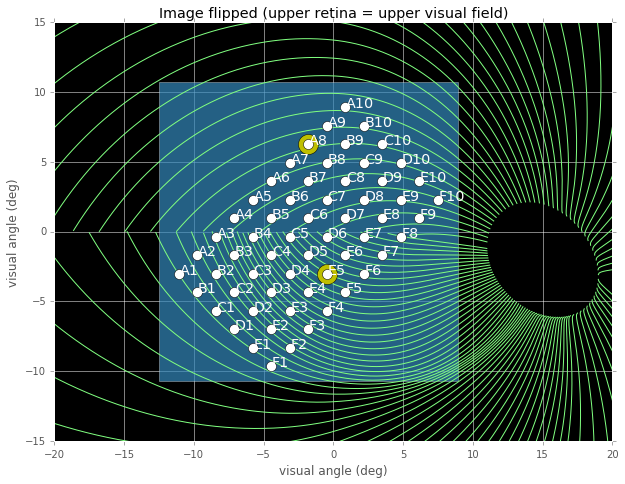

In [6]:
from matplotlib import patches

# Plot axon bundles (plot every 5th for the sake of visualization)
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.set_axis_bgcolor('black')
ax.plot(retina.jan_x[:, ::5], -retina.jan_y[:, ::5], c=(0.5, 1, 0.5))

# Draw in the the retinal patch we're simulating.
# This defines the size of our "percept" image below.
ax.add_patch(patches.Rectangle((e2cm.micron2deg(retina.gridx.min()), 
                                -e2cm.micron2deg(retina.gridy.max())),
                               e2cm.micron2deg(retina.gridx.max() - retina.gridx.min()),
                               e2cm.micron2deg(retina.gridy.max() - retina.gridy.min()),
                               alpha=0.7))

# Plot location of stimulated electrodes
for key in stim:
    ax.plot(e2cm.micron2deg(argus[key].x_center),
            -e2cm.micron2deg(argus[key].y_center), 'oy',
            markersize=np.sqrt(argus[key].radius)*2)

# Plot all electrodes and their label
for e in argus.electrodes:
    ax.text(e2cm.micron2deg(e.x_center + 10), -e2cm.micron2deg(e.y_center + 5), e.name,
            color='white', size='x-large')
    ax.plot(e2cm.micron2deg(e.x_center), -e2cm.micron2deg(e.y_center), 'ow',
            markersize=np.sqrt(e.radius))

ax.set_aspect('equal')
ax.set_xlim(-20, 20)
ax.set_xlabel('visual angle (deg)')
ax.set_ylim(-15, 15)
ax.set_ylabel('visual angle (deg)')
ax.set_title('Image flipped (upper retina = upper visual field)')
fig.savefig('jansonius_argusII.png')

In [7]:
ecs, cs = retina.electrode_ecs(argus)

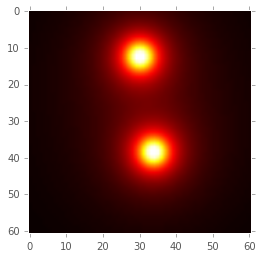

In [8]:
plt.imshow(cs[..., 1, argus.get_index('A8')] + cs[..., 1, argus.get_index('E5')], cmap='hot')
plt.grid('off')
plt.savefig('cs.png')

In [9]:
mov = ec2b.pulse2percept(stim, argus, tm, retina, n_jobs=8, dojit=True, tol=0.10)

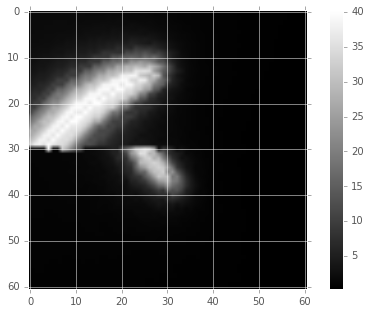

In [10]:
frame = ec2b.get_brightest_frame(mov)
plt.figure(figsize=(8, 5))
plt.imshow(frame.data, cmap='gray')
plt.colorbar()
plt.savefig('percept')

In [11]:
def dva2ret(r_deg):
    r_mm = 0.268 * r_deg + 3.427e-4 * r_deg ** 2 - 8.3309e-6 * r_deg ** 3
    return 1e3 * r_mm

In [12]:
def ret2dva(r_um):
    r_mm = 1e-3 * r_um
    return 3.556 * r_mm + 0.05993 * r_mm ** 2 - 0.007358 * r_mm ** 3 + 3.027e-4 * r_mm ** 4

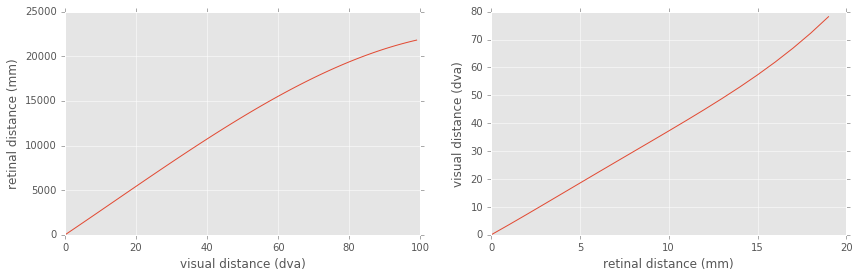

In [13]:
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.plot(np.arange(100), dva2ret(np.arange(100)))
plt.xlabel('visual distance (dva)')
plt.ylabel('retinal distance (mm)')

plt.subplot(122)
plt.plot(np.arange(20), ret2dva(np.arange(20) * 1000))
plt.xlabel('retinal distance (mm)')
plt.ylabel('visual distance (dva)')

In [14]:
from scipy import stats
def displace(r, meridian='temporal'):
    if meridian == 'temporal':
        alpha = 1.8938
        beta = 2.4598
        gamma = 0.91565
        delta = 14.904
        mu = -0.09386
    else:
        alpha = 2.4607
        beta = 1.7463
        gamma = 0.77754
        delta = 15.111
        mu = -0.15933
    
    rmubeta = (r - mu) / beta
    numer = delta * gamma * np.exp(-rmubeta ** gamma) * rmubeta ** (alpha * gamma - 1)
    denom = beta * stats.gamma.pdf(alpha, 5)

    return numer / denom / 12.0

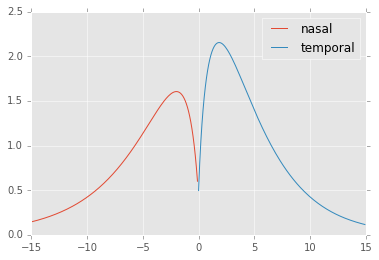

In [15]:
plt.plot(np.arange(-15, 0, 0.1), displace(np.arange(15, 0, -0.1), 'nasal'), label='nasal')
plt.plot(np.arange(0, 15, 0.1), displace(np.arange(0, 15, 0.1), 'temporal'), label='temporal')
plt.legend()

In [16]:
from skimage.io import imread
from skimage.transform import warp

In [17]:
def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho

In [18]:
def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y

In [19]:
def warp_img(xy, xy_center, r_sampling=100.0):
    theta, rho_old = cart2pol((xy[:, 0] - xy_center[0]) * r_sampling,
                              (xy[:, 1] - xy_center[1]) * r_sampling)
    rho_old = ret2dva(rho_old)
#     rho_old[rho_old < ret2dva(150)] = 1e6
    
    # TODO: temporal vs nasal
    rho_new = rho_old - displace(rho_old, 'nasal')
    rho_new = dva2ret(rho_new)
    
    # Remove foveola
#     rho_new[rho_old < ret2dva(150)] = 1e6
    
    # Back to Cartesian
    x_new, y_new = pol2cart(theta, rho_new)
    
    # Back to image coordinates
    x_new /= r_sampling
    y_new /= r_sampling

    return np.hstack((x_new + xy_center[0], y_new + xy_center[1]))

In [20]:
checker = imread('checkerboard.jpg', as_grey=True)
deltax = r_sampling / checker.shape[0] * frame.data.shape[0]

In [21]:
img2 = warp(checker, inverse_map=warp_img, map_args={'xy_center': [100, 100], 'r_sampling': deltax})

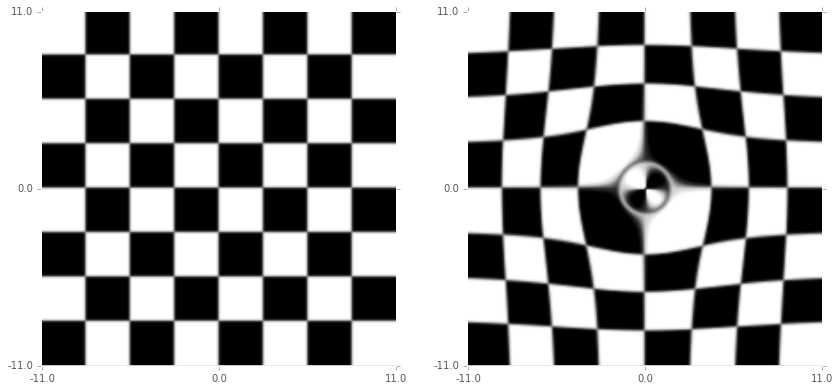

In [22]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(checker, cmap='gray')
plt.grid('off')
plt.xticks([0, 100, 200], np.round(ret2dva(np.array([-110 * deltax, 0, 100 * deltax]))))
plt.yticks([0, 100, 200], np.round(ret2dva(np.array([100 * deltax, 0, -110 * deltax]))))

plt.subplot(122)
plt.imshow(img2, cmap='gray')
plt.grid('off')
plt.xticks([0, 100, 200], np.round(ret2dva(np.array([-110 * deltax, 0, 100 * deltax]))))
plt.yticks([0, 100, 200], np.round(ret2dva(np.array([100 * deltax, 0, -110 * deltax]))))
plt.savefig('displacement.png')

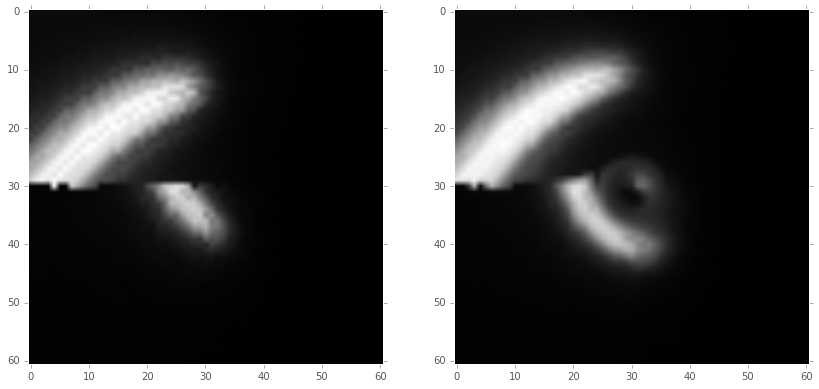

In [23]:
plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(frame.data, cmap='gray')
plt.grid('off')

plt.subplot(122)
plt.imshow(warp(frame.data, inverse_map=warp_img,
                map_args={'xy_center': np.array(frame.data.shape[:2]) / 2.0, 'r_sampling': r_sampling}),
           cmap='gray')
plt.grid('off')
plt.savefig('displacement-argus.png')